$\begin{align}
	&u_t + c(x)u_x = 0, \text{ em } [0,5] \times [0,6.4], \\
	&u(x,0) = f(x), \\~\\
	&c(x) = 1/5+\sin(x-1)^2, \\
	&f(x) = e^{-100(x-1)^2}
\end{align}$

In [13]:
using Plots, JLD, Random, LinearAlgebra
Random.seed!(123)

TaskLocalRNG()

In [14]:
function Upwind(u0,x,t,λ)
	u = zeros(length(t),length(x))
	u[1,:] = u0
	for n = 1:length(t)-1
		u[n+1,1] = 0 
		for j = 2:length(x)
			u[n+1,j] = u[n,j] - λ[j]*(u[n,j] - u[n,j-1])
		end 
	end
	return u
end

Upwind (generic function with 1 method)

In [15]:
xmin = 0; xmax = 5; Δx = 0.01
tmin = 0; tmax = 6.4; Δt = Δx/1.2
x = xmin:Δx:xmax; t = tmin:Δt:tmax
c(x) = 1/5+sin(x-1)^2
λ = c.(x)*Δt/Δx
f(x) = exp(-100*(x-1)^2)
u0 = f.(x)
u = Upwind(u0,x,t,λ);

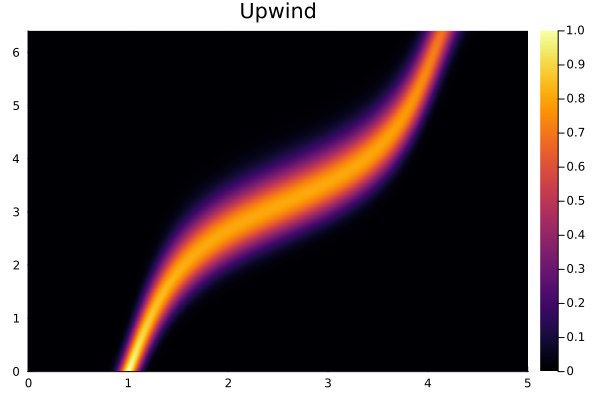

In [16]:
heatmap(x, t, u, title="Upwind")

In [17]:
u_x = zeros(length(t),length(x))
u_t = zeros(length(t),length(x))
u_g = zeros(length(t),length(x)) # norma do gradiente
LX = length(x)
LT = length(t)

for n = 1:length(t)
    u_x[n,1] = (-3*u[n,1]+4*u[n,2]-u[n,3])/(2*Δx)
    u_x[n,LX] = (u[n,LX-2]-4*u[n,LX-1]+3*u[n,LX])/(2*Δx)
    for j = 2:length(x)-1
        u_x[n,j] = (-u[n,j-1]+u[n,j+1])/(2*Δx)
    end
end

for j = 1:length(x)
    u_t[1,j] = (-3*u[1,j]+4*u[2,j]-u[3,j])/(2*Δt)
    u_t[LT,j] = (u[LT-2,j]-4*u[LT-1,j]+3*u[LT,j])/(2*Δt)
    for n = 2:length(t)-1
        u_t[n,j] = (-u[n-1,j]+u[n+1,j])/(2*Δt)
    end
end

for n = 1:length(t)
    for j = 1:length(x)
        u_g[n,j] = u_x[n,j]^2 + u_t[n,j]^2
    end
end

In [18]:
Dados = zeros(length(u),4) 
Indices_disponiveis = zeros(Int, length(u))
k = 1
for n = 1:length(t)
    for j = 1:length(x)
        Indices_disponiveis[k] = k
        Dados[k,1] = x[j]
        Dados[k,2] = t[n]
        Dados[k,3] = u[n,j]
        Dados[k,4] = u_g[n,j]
        k += 1
    end
end
Dados

385269×4 Matrix{Float64}:
 0.0   0.0  3.72008e-44  2.41887e-81
 0.01  0.0  2.72143e-43  9.90939e-81
 0.02  0.0  1.95145e-42  4.90652e-79
 0.03  0.0  1.37161e-41  2.32642e-77
 0.04  0.0  9.44975e-41  1.05971e-75
 0.05  0.0  6.3815e-40   4.63726e-74
 0.06  0.0  4.22415e-39  1.94947e-72
 0.07  0.0  2.74076e-38  7.87313e-71
 0.08  0.0  1.74307e-37  3.05459e-69
 0.09  0.0  1.08661e-36  1.1385e-67
 ⋮                       
 4.92  6.4  2.39835e-6   2.65026e-9
 4.93  6.4  2.01687e-6   1.87561e-9
 4.94  6.4  1.69729e-6   1.32948e-9
 4.95  6.4  1.42934e-6   9.43822e-10
 4.96  6.4  1.20452e-6   6.71058e-10
 4.97  6.4  1.01575e-6   4.77837e-10
 4.98  6.4  8.57129e-7   3.4075e-10
 4.99  6.4  7.23744e-7   2.43342e-10
 5.0   6.4  6.115e-7     1.7052e-10

In [19]:
n_dados = 2000
n_trocados = 750

# Pegando n_dados linhas de Dados
indices_sorteados = randperm(length(u))[1:n_dados]
Dados_sorteados = Dados[indices_sorteados, :] 

for i = 1:10
    v = Dados_sorteados[:,4]
    mv = norm(v)
    println(mv)

    # Separando as linhas de Dados que não foram pegas
    indices_N_sorteados = setdiff(1:length(u), indices_sorteados)
    Dados_N_sorteados = Dados[indices_N_sorteados, :] 

    # Ordenando Dados_sorteados pela norma do gradiente (quarta coluna)
    Dados_sorteados = Dados_sorteados[sortperm(Dados_sorteados[:, 4], rev=true), :] 

    # Pegando as n_trocados linhas de Dados_sorteados que tem a menor norma do gradiente 
    Dados_Ruins = Dados_sorteados[end-n_trocados+1:end, :] 

    # Deixando Dados_sorteados com as n_dados - n_trocados primeiras linhas 
    Dados_sorteados = Dados_sorteados[1:n_dados-n_trocados, :]

    # Acrescentando n_trocados linhas a Dados_sorteados para ficar com n_dados linha de novo. 
    # Essas linhas vem de Dados_N_sorteados
    indices_novos = randperm(size(Dados_N_sorteados, 1))[1:n_trocados]
    novas_linhas = Dados_N_sorteados[indices_novos, :]
    Dados_sorteados = vcat(Dados_sorteados, novas_linhas)

    # Retirando de Dados_N_sorteados as linhas que foram acrescentadas a Dados_sorteados
    Dados_N_sorteados = Dados_N_sorteados[setdiff(1:end, indices_novos), :]
end

209.99602879651508
255.03332596167337
284.10489460570886
310.19725766322756
330.08498968020655
342.5856208944218
353.27025217665323
376.6921942055745
401.4162424667098
420.7092958162341


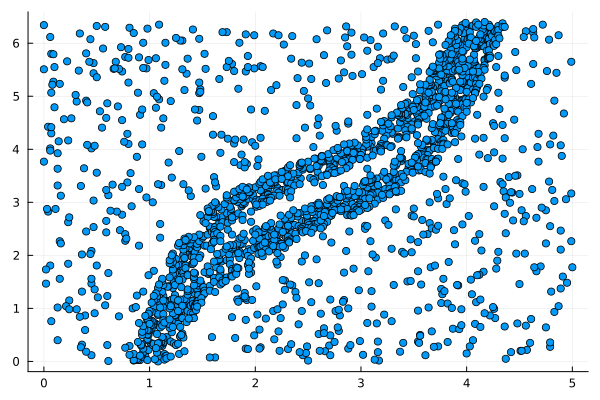

In [20]:
let 
    x = Dados_sorteados[:,1]
    t = Dados_sorteados[:,2]
    scatter(x, t, legend=false)
end

In [21]:
xt_D = Dados_sorteados[:,1:2]
u_D = Dados_sorteados[:,3]
D = [xt_D, u_D]
save("Upwind_Dados_grad.jld", "D", D)